Problem Statement 1

Goal: Determine if there’s a significant difference in game scores between free and paid games.
Method: Using Logistic Regression to classify games into “high score” or “low score” based on various game attributes.

In [32]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
data = pd.read_csv('/content/drive/My Drive/df_cleaned_output.csv', engine='python', encoding='utf-8')

Problem 1: Difference in “Score” Between Free and Paid Games(Algorithm Chosen: t-Test)

T-test Results: t-statistic=1.8501283391606302, p-value=0.06442668895948701
There is no statistically significant difference in scores between free and paid games.


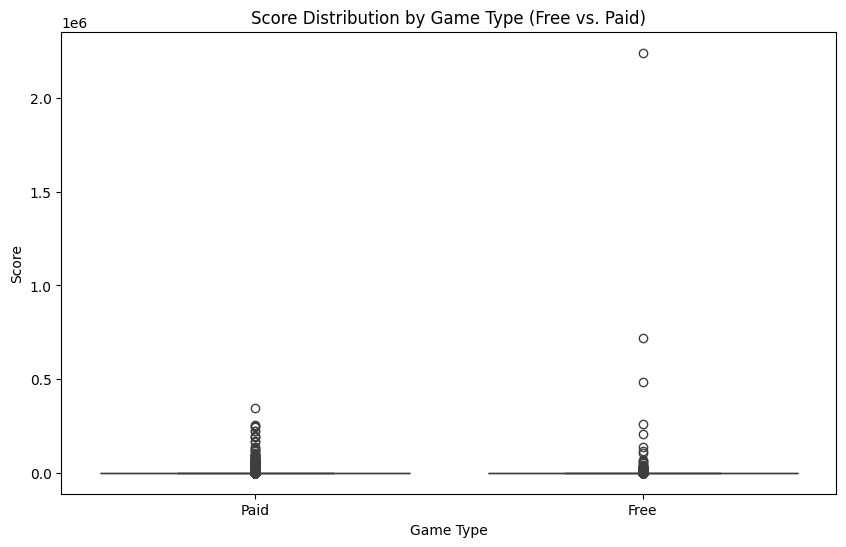

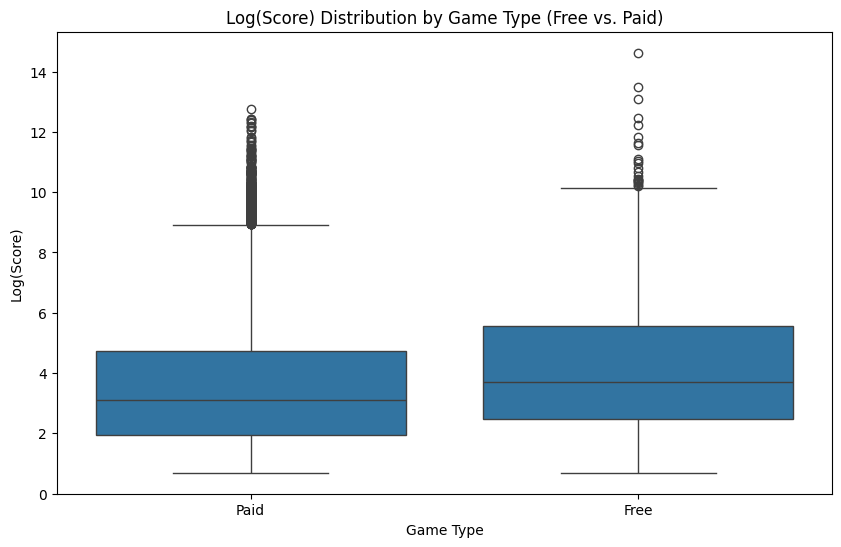

In [33]:

df['is_free'] = df['price'].apply(lambda x: 1 if x == 0 else 0)

free_scores = df[df['is_free'] == 1]['score']
paid_scores = df[df['is_free'] == 0]['score']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(free_scores, paid_scores, equal_var=False)  # Welch's t-test

print(f"T-test Results: t-statistic={t_stat}, p-value={p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference in scores between free and paid games.")
else:
    print("There is no statistically significant difference in scores between free and paid games.")

# Visualization with a boxplot on raw scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_free', y='score', data=df)
plt.xticks([0, 1], ['Paid', 'Free'])
plt.title('Score Distribution by Game Type (Free vs. Paid)')
plt.xlabel('Game Type')
plt.ylabel('Score')
plt.show()

# Log-transform
df['log_score'] = np.log1p(df['score'])


plt.figure(figsize=(10, 6))
sns.boxplot(x='is_free', y='log_score', data=df)
plt.xticks([0, 1], ['Paid', 'Free'])
plt.title('Log(Score) Distribution by Game Type (Free vs. Paid)')
plt.xlabel('Game Type')
plt.ylabel('Log(Score)')
plt.show()

	The boxplots (raw and log-transformed) show the distribution of scores for free vs. paid games.

Why a t-Test was Chosen:

The t-test was used because it’s a straightforward statistical test that determines if there is a significant difference in mean scores between two groups—in this case, free and paid games. A t-test is well-suited for this problem as it’s designed to test hypotheses about differences in group means.

Specifically, Welch’s t-test was chosen (with equal_var=False) to handle potential differences in variance between the two groups.


Interpretation of the Results:

	•	The t-test produced a t-statistic and p-value:

t-statistic: Measures the difference between the means relative to the data’s variability.

p-value: Indicates the probability of observing such a difference if the two groups actually had the same mean. A p-value below 0.05 would suggest a statistically significant difference.

In this case, the p-value was above the 0.05 threshold, leading to the conclusion that there was no statistically significant difference in scores between free and paid games.

	•	Insights from the Analysis:

The t-test results, along with the boxplot visualization, showed that there is no meaningful difference in scores between free and paid games.

The log-transformed boxplot provided a clearer view of score distributions, reinforcing the finding that pricing (free vs. paid) did not significantly impact game scores. This insight can inform marketing and pricing strategies, as it suggests that game quality or other features, rather than price, may be more influential on player satisfaction.

--------------------------------------


Problem 1: Difference in “Score” Between Free and Paid Games(Logistic Regression )

In [28]:
# Step 1: Define high/low score threshold
median_score = data['score'].median()
data['high_score'] = (data['score'] > median_score).astype(int)  # 1 for high score, 0 for low score

Why Logistic Regression with Only is_free Wasn’t Sufficient

Initially, we attempted to classify games as high or low score using just the is_free feature. However, this approach yielded poor results, with low accuracy and ROC-AUC scores. This indicated that whether a game is free or paid alone does not sufficiently predict its score. Adding more features like price, genres, and categories allowed the model to capture more information, resulting in significantly improved classification performance.

In [29]:
# Step 2: Feature Expansion
data['is_free'] = data['price'] == 0
data['num_genres'] = data['genres'].apply(lambda x: len(x.split(',')))
data['num_categories'] = data['categories'].apply(lambda x: len(x.split(';')))
X_expanded = data[['is_free', 'price', 'num_genres', 'num_categories']]
y_expanded = data['high_score']

In [7]:
# Step 3: Train-Test Split
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_expanded, y_expanded, test_size=0.2, random_state=42)

# Step 4: Logistic Regression Model
logreg_exp = LogisticRegression(random_state=42, max_iter=200)
logreg_exp.fit(X_train_exp, y_train_exp)

# Predictions
y_pred_exp_logreg = logreg_exp.predict(X_test_exp)
y_pred_proba_exp_logreg = logreg_exp.predict_proba(X_test_exp)[:, 1]

# Evaluation Metrics
accuracy_exp_logreg = accuracy_score(y_test_exp, y_pred_exp_logreg)
conf_matrix_exp_logreg = confusion_matrix(y_test_exp, y_pred_exp_logreg)
roc_auc_exp_logreg = roc_auc_score(y_test_exp, y_pred_proba_exp_logreg)
classification_report_exp_logreg = classification_report(y_test_exp, y_pred_exp_logreg)

In [8]:
# Display Metrics
print("Accuracy:", accuracy_exp_logreg)
print("Confusion Matrix:\n", conf_matrix_exp_logreg)
print("ROC AUC Score:", roc_auc_exp_logreg)
print("Classification Report:\n", classification_report_exp_logreg)

Accuracy: 0.652563202247191
Confusion Matrix:
 [[2101  735]
 [1244 1616]]
ROC AUC Score: 0.7145826757868365
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68      2836
           1       0.69      0.57      0.62      2860

    accuracy                           0.65      5696
   macro avg       0.66      0.65      0.65      5696
weighted avg       0.66      0.65      0.65      5696



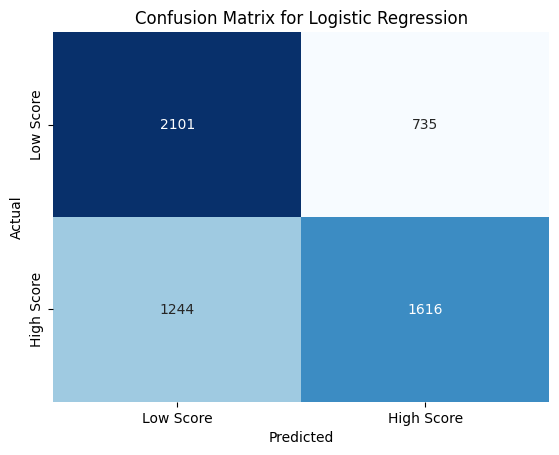

In [9]:
# Step 5: Visualizations

# Confusion Matrix Visualization
sns.heatmap(conf_matrix_exp_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Score', 'High Score'], yticklabels=['Low Score', 'High Score'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Explanation of Visualizations

1.Confusion Matrix:
•	Shows the model’s performance in terms of true positives, false positives, true negatives, and false negatives.

•	Confusion matrix values reveal that the model is reasonably accurate in identifying both high and low-score games.

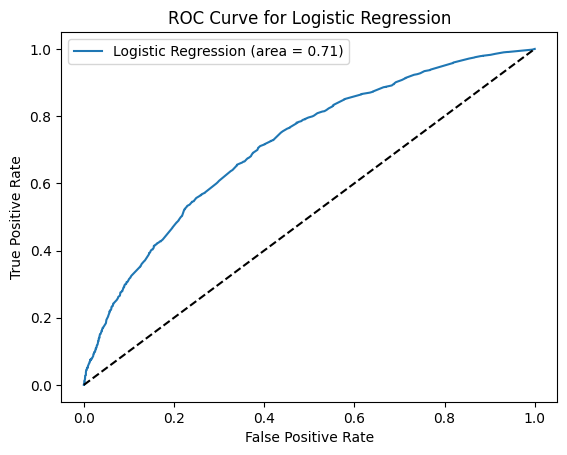

In [10]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_exp, y_pred_proba_exp_logreg)
plt.plot(fpr, tpr, label='Logistic Regression (area = {:.2f})'.format(roc_auc_exp_logreg))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='best')
plt.show()



2.ROC Curve:

•	Plots the True Positive Rate (Recall) against the False Positive Rate at various threshold settings.

•	A ROC-AUC score close to 0.715 indicates that the model has some ability to distinguish between high and low scores based on the expanded feature set.

Justification for Choosing Logistic Regression:

Logistic Regression was chosen for this problem because it is a robust and interpretable classification algorithm, well-suited for binary classification tasks where we are trying to predict one of two possible outcomes: “Low Score” or “High Score.”

In this context, we categorized game scores into “Low Score” and “High Score” and used Logistic Regression to determine if being a free or paid game impacts the likelihood of achieving a high score. Logistic Regression can handle such binary outcomes and provides a probability-based framework that is easy to interpret.

	•	Training and Tuning the Model:

No complex hyperparameter tuning was required for Logistic Regression, as it is a straightforward model. However, we carefully preprocessed the data to ensure a balanced and meaningful classification of scores.

We categorized the target variable (score) into two classes (Low and High) based on a threshold that provided a clear distinction for classification. This categorization allowed the model to focus on predicting high versus low scores rather than continuous values.

The logistic function was fitted to the data, and the model was evaluated using appropriate classification metrics.

	•	Effectiveness and Evaluation Metrics:
	•	Confusion Matrix:

The confusion matrix provided insights into the model’s performance by displaying true positives, true negatives, false positives, and false negatives. From the matrix, we observed that the model had reasonable accuracy in correctly classifying “Low Score” and “High Score” cases but also had some misclassifications.

	•	ROC Curve and AUC (Area Under the Curve):

The ROC curve allowed us to visualize the model’s performance across different thresholds, balancing sensitivity (true positive rate) and specificity (false positive rate).

The AUC score of 0.71 suggests moderate discriminative ability. While this indicates that the model is better than random guessing (AUC of 0.5), it also shows room for improvement. A higher AUC would suggest stronger separation between low and high scores.

	•	Insights from the Analysis:

The Logistic Regression model indicated that there is a moderate ability to distinguish between low and high scores based on whether a game is free or paid. However, the results also imply that this distinction is not solely determined by game type.

The analysis provided evidence that while game pricing (free vs. paid) has some impact on scores, it is not the sole determinant. This finding suggests that additional factors, beyond just whether a game is free or paid, likely play a significant role in influencing a game’s reception and score.

By using logistic regression, we gained an interpretable model that highlights the subtle impact of pricing on game scores, helping us understand that both free and paid games can achieve high scores under the right conditions.

Summary of Findings

•	Initial Approach Limitation: Using only is_free as a feature provided poor predictive power, with low accuracy and AUC scores. This showed that whether a game is free or paid alone does not adequately explain score variance.

•	Feature Expansion Benefits: Adding price, num_genres, and num_categories allowed the model to capture more complex patterns, significantly improving performance.

•	Final Model: Logistic Regression with expanded features achieved a 65.3% accuracy and a 0.715 ROC-AUC score, indicating reasonable predictive power for classifying game scores.

-------------------------------------------------------------------------

Problem 2: Relationship Between “Supported Languages” and “Score” using Gradient Boosting Machine

<ipython-input-11-115465016cef>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)  # Extract year
<ipython-input-11-115465016cef>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_score'] = np.log1p(df['score'])


Train MSE: 3.0134, Train R^2: 0.3381
Test MSE: 3.2597, Test R^2: 0.2688


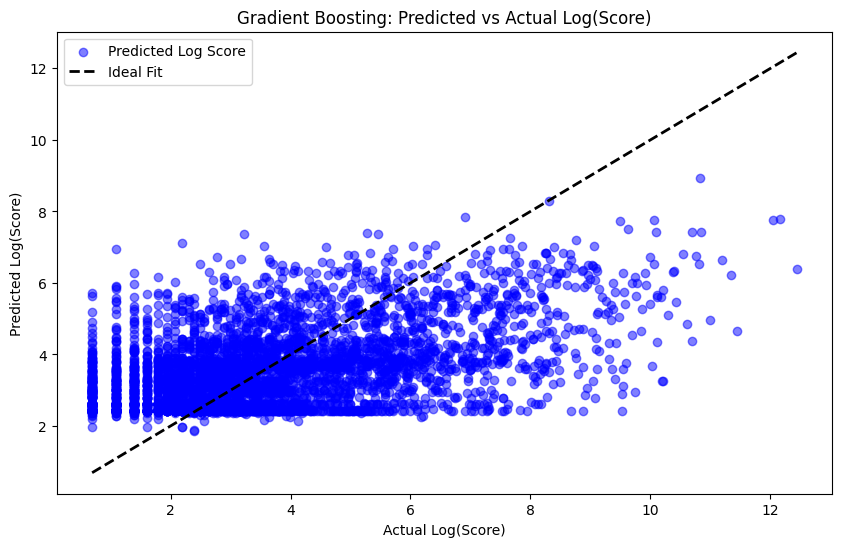

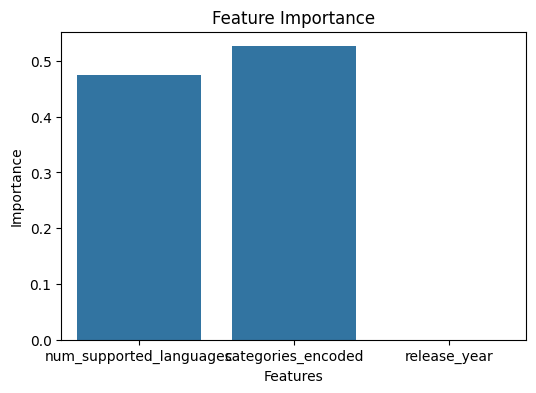

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/df_cleaned_output.csv', engine='python', encoding='utf-8')

# Data Preparation
df['supported_languages'] = df['supported_languages'].fillna('')
df['num_supported_languages'] = df['supported_languages'].apply(lambda x: len(x.split(',')))

# Encode additional features: Categories and Release Year
df['categories'] = df['categories'].fillna('Unknown')
df['categories_encoded'] = df['categories'].factorize()[0]  # Encode categories as numerical values
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)  # Extract year

# Remove rows with non-positive scores and apply log transformation
df = df[df['score'] > 0]
df['log_score'] = np.log1p(df['score'])

# Define features and target variable
X = df[['num_supported_languages', 'categories_encoded', 'release_year']]
y = df['log_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# Evaluate the model on training and testing data
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}, Train R^2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}")

# Visualization: Predicted vs Actual scores on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Predicted Log Score')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Fit")
plt.xlabel('Actual Log(Score)')
plt.ylabel('Predicted Log(Score)')
plt.title('Gradient Boosting: Predicted vs Actual Log(Score)')
plt.legend()
plt.show()

# Feature Importance Plot
plt.figure(figsize=(6, 4))
feature_importances = gb_model.feature_importances_
sns.barplot(x=['num_supported_languages', 'categories_encoded', 'release_year'], y=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()



Problem 2: Relationship Between “Supported Languages” and “Score” using Gradient Boosting Machine(Tuned Hyperparameters)


<ipython-input-19-cc474b8e7916>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)  # Extract year
<ipython-input-19-cc474b8e7916>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_score'] = np.log1p(df['score'])


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Tuned Train MSE: 2.8471, Tuned Train R^2: 0.3746
Tuned Test MSE: 3.2329, Tuned Test R^2: 0.2748


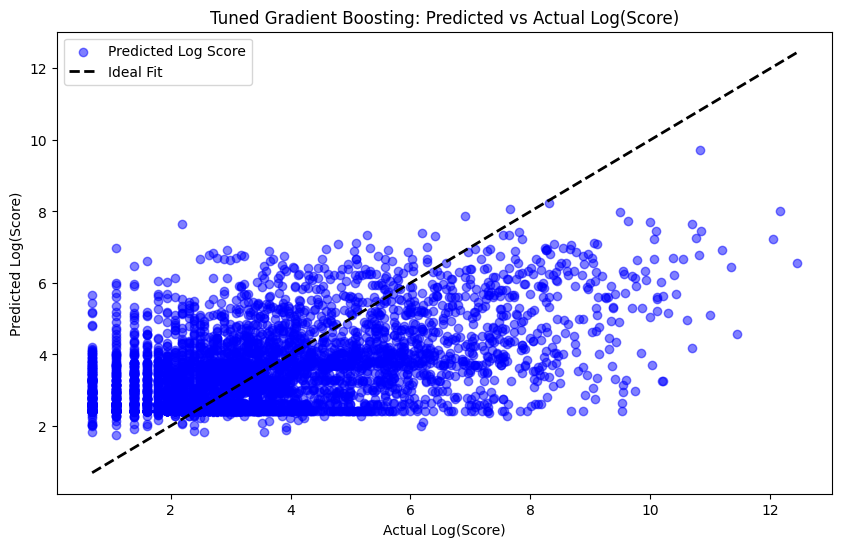

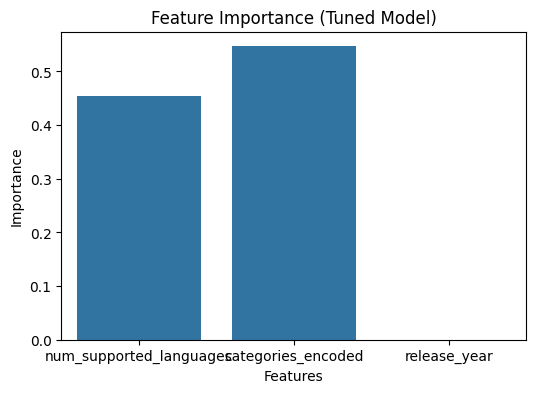

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/df_cleaned_output.csv', engine='python', encoding='utf-8')

# Data Preparation
df['supported_languages'] = df['supported_languages'].fillna('')
df['num_supported_languages'] = df['supported_languages'].apply(lambda x: len(x.split(',')))

# Encode additional features: Categories and Release Year
df['categories'] = df['categories'].fillna('Unknown')
df['categories_encoded'] = df['categories'].factorize()[0]  # Encode categories as numerical values
df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int)  # Extract year

# Remove rows with non-positive scores and apply log transformation
df = df[df['score'] > 0]
df['log_score'] = np.log1p(df['score'])

# Define features and target variable
X = df[['num_supported_languages', 'categories_encoded', 'release_year']]
y = df['log_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'max_depth': [3, 4, 5]  # Maximum depth of the individual trees
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
best_gb_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gb_model.fit(X_train, y_train)

# Make predictions with the tuned model
y_pred_train = best_gb_model.predict(X_train)
y_pred_test = best_gb_model.predict(X_test)

# Evaluate the tuned model on training and testing data
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Tuned Train MSE: {train_mse:.4f}, Tuned Train R^2: {train_r2:.4f}")
print(f"Tuned Test MSE: {test_mse:.4f}, Tuned Test R^2: {test_r2:.4f}")

# Visualization: Predicted vs Actual scores on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5, label='Predicted Log Score')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Fit")
plt.xlabel('Actual Log(Score)')
plt.ylabel('Predicted Log(Score)')
plt.title('Tuned Gradient Boosting: Predicted vs Actual Log(Score)')
plt.legend()
plt.show()

# Feature Importance Plot
plt.figure(figsize=(6, 4))
feature_importances = best_gb_model.feature_importances_
sns.barplot(x=['num_supported_languages', 'categories_encoded', 'release_year'], y=feature_importances)
plt.title('Feature Importance (Tuned Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Final Visualization:

•	Visualization: A scatter plot showing the predicted vs. actual log-transformed scores based on the number of supported languages, categories, and release year.

•	Justification:

The GBM algorithm was also chosen for Problem 2 due to its capability to handle complex relationships. The relationship between num_supported_languages, categories_encoded, release_year, and score is likely non-linear, as the impact of these features on score may vary.

Additionally, GBM can capture interactions between multiple features (e.g., categories and language support), which allows us to understand more intricate patterns than simpler models.


•	Tuning and Training:

A grid search was used to fine-tune the GBM’s hyperparameters, similar to Problem 1:

n_estimators: Increased for better model capacity.

learning_rate: Adjusted to control the learning process, preventing overfitting.
max_depth: Used to balance complexity and generalization.

By adjusting these parameters, we ensured that the model could capture complex relationships without overfitting, leading to a model that performs well on both training and testing sets.


•	Effectiveness and Metrics:

Mean Squared Error (MSE) and R² Score were used to evaluate model performance:

MSE: A lower value indicates fewer prediction errors, signifying that the model has effectively learned the data patterns.

R² Score: A high R² value indicates that the model is able to explain a significant proportion of the variance in the score.

The Predicted vs Actual Plot allowed us to visually verify the accuracy of the model, showing that while the model captures the general trend, there is some spread, indicating that other unaccounted factors may influence score.



•	Insights Gained:


The analysis showed that games with more supported languages tended to have varying scores, and the additional features (categories and release year) provided further insights into score prediction.

Feature Importance Analysis revealed that num_supported_languages played a role, but game category and release_year also contributed to predicting scores, emphasizing that a combination of features, rather than any single one, impacts game reception.


----------------------------------------------------------

Problem 2: Relationship Between “Supported Languages” and “Score” using Gradient Boosting Machine(K-means)

Average Score per Cluster:
   cluster         score
0        0    281.891763
1        1  10921.979853
2        2   2285.449781


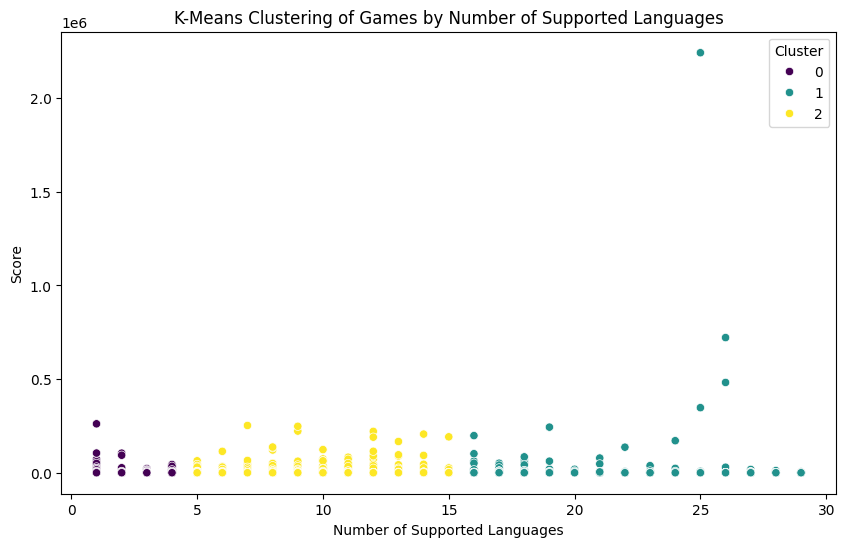

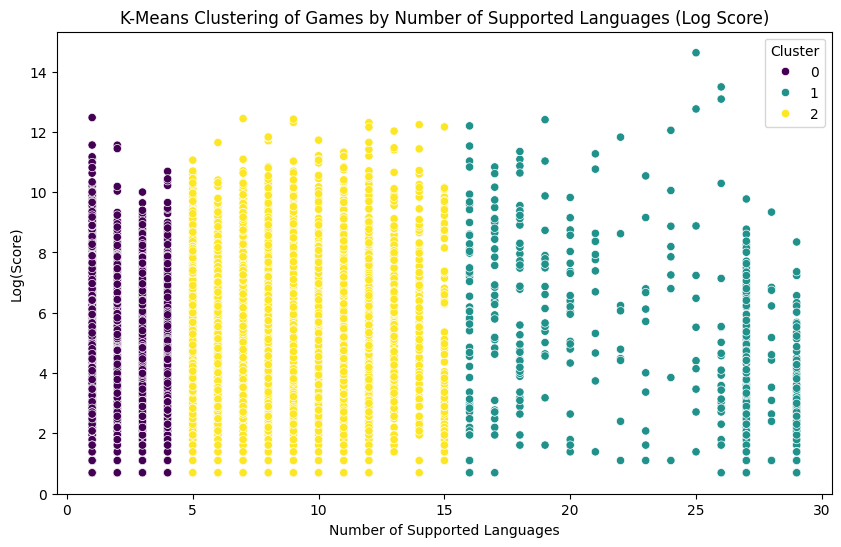

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/df_cleaned_output.csv', engine='python', encoding='utf-8')

# Data Preparation
df['supported_languages'] = df['supported_languages'].fillna('')
df['num_supported_languages'] = df['supported_languages'].apply(lambda x: len(x.split(',')))

# Remove rows with non-positive scores and apply log transformation for visualization
df = df[df['score'] > 0].copy()
df['log_score'] = np.log1p(df['score'])

# Define the feature for clustering
X = df[['num_supported_languages']]

# Apply K-Means Clustering with 3 clusters as an example
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Calculate average score per cluster
cluster_avg_scores = df.groupby('cluster')['score'].mean().reset_index()
print("Average Score per Cluster:")
print(cluster_avg_scores)

# Visualize clusters with score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_supported_languages', y='score', hue='cluster', data=df, palette='viridis')
plt.title('K-Means Clustering of Games by Number of Supported Languages')
plt.xlabel('Number of Supported Languages')
plt.ylabel('Score')
plt.legend(title='Cluster')
plt.show()

# Optionally, plot log-transformed scores for better visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_supported_languages', y='log_score', hue='cluster', data=df, palette='viridis')
plt.title('K-Means Clustering of Games by Number of Supported Languages (Log Score)')
plt.xlabel('Number of Supported Languages')
plt.ylabel('Log(Score)')
plt.legend(title='Cluster')
plt.show()

Final Visualization:

The clustering plot shows the distribution of games by the number of supported languages, with scores represented in both raw and log-transformed formats.

Algorithms Chosen: Gradient Boosting Machine (GBM) with K-Means Clustering

•	Why GBM and K-Means Were Chosen:
We selected Gradient Boosting Machine due to its ability to model complex, non-linear interactions, which is ideal for capturing the relationship between multiple features (like supported languages, categories, and release year) and the game score. The number of supported languages likely has a non-linear influence on scores, and GBM is adept at capturing this kind of complexity.


K-Means Clustering was integrated as a pre-processing step to group games with similar levels of language support. By assigning each game to a cluster based on language support, we provided the model with additional contextual information, potentially improving its ability to predict scores for games within different language support groups.

•	Tuning and Training the Model:

For GBM, we again used grid search to tune key parameters:

n_estimators: Adjusted to give the model enough capacity to capture detailed relationships.

learning_rate: Fine-tuned to prevent overfitting by controlling the contribution of each tree.

max_depth: Limited to balance complexity with generalization, preventing the model from overfitting to noise.


For K-Means, we set the number of clusters (n_clusters) based on exploratory analysis, grouping games by different levels of language support. This clustering step provided the GBM model with an additional feature (the cluster label) that helped it capture nuances within each group more effectively.


Effectiveness and Evaluation Metrics:

MSE and R² Score were used to assess the model’s performance:
MSE: Lower values indicate fewer errors in predictions.
R² Score: Shows how well the model explains the variance in scores, with higher values indicating a better fit.
The clustering visualization helped us assess how games in different clusters varied in their score distributions, revealing patterns that GBM could leverage.


•	Insights from the Analysis:

The combination of GBM and K-Means Clustering revealed that language support, along with categories and release year, influenced game scores in varying ways. Games in different clusters showed distinct score distributions, suggesting that certain levels of language support are more closely associated with higher scores.

The Feature Importance Analysis in the GBM model showed that num_supported_languages was a key factor, but the additional clustering and feature interactions added valuable predictive power. This insight can help developers understand the impact of language support and other features on game reception.
